# Problem 5: Wavelet denoising
Prof. V. I. Morgenshtern

Solver: A. Regensky

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import csv
import pywt
import cvxpy as cvx

In class we talked about denoising via wavelet shrinkage at the level $\sigma \sqrt{2\log{n}}$, where $\sigma^2$ is the variance of the noise. In this exercise you are provided with four signal that are stored as columns of the text file clean_signal.txt. The noisy versions of the same signals are stored as columns of the text file noisy_signal.txt, $\sigma = 1$. You can use the read_data.ipynb to read the data.

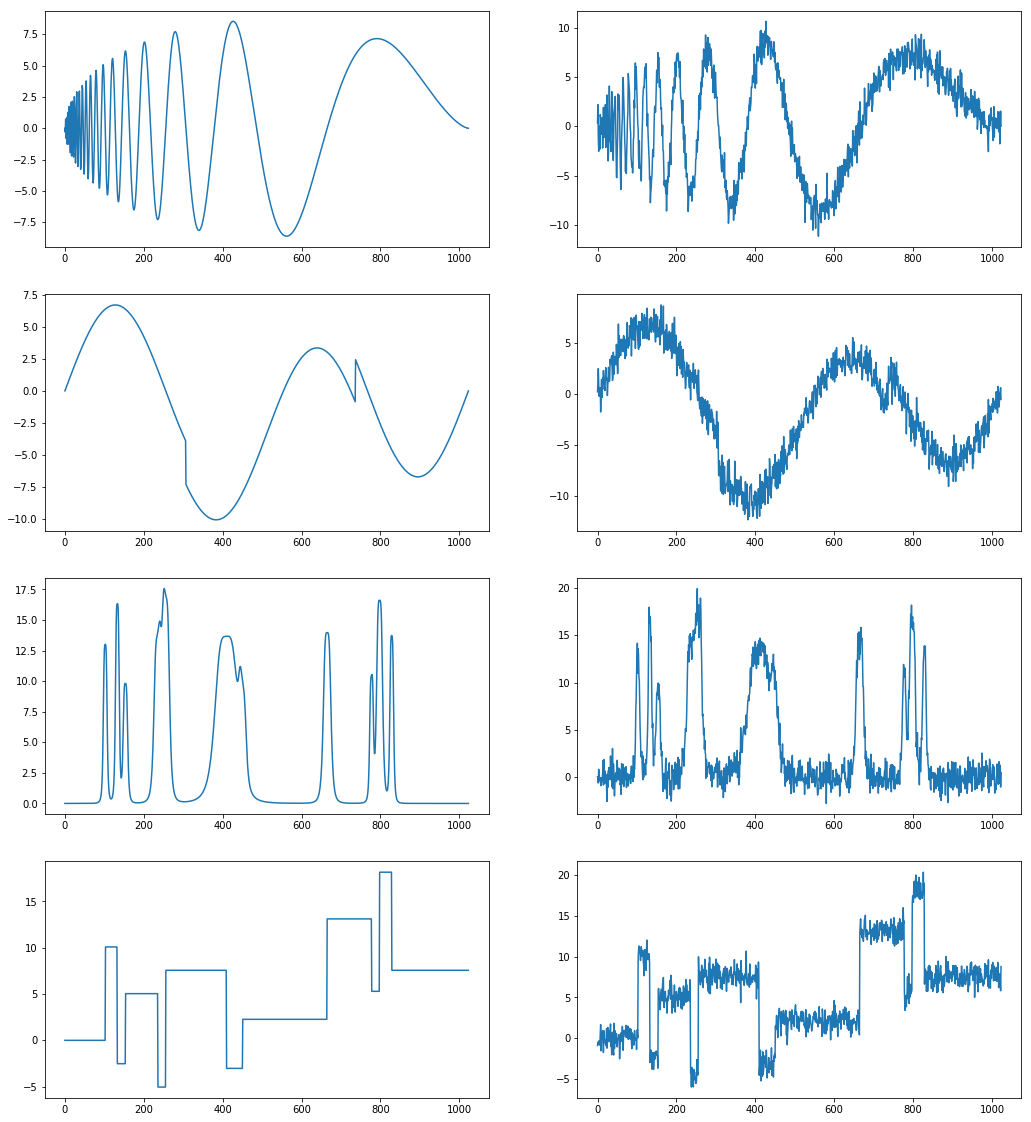

In [2]:
# Read the clean signal
with open("clean_signal.txt") as f:
    reader = csv.reader(f)
    data = []
    for r in reader:
        row = r[0].split()
        rownum = [float(el) for el in row]
        data.append(rownum)
clean_signal = np.array(data)

# Read the noisy signal
with open("noisy_signal.txt") as f:
    reader = csv.reader(f)
    datan = []
    for r in reader:
        row = r[0].split()
        rownum = [float(el) for el in row]
        datan.append(rownum)
noisy_signal = np.array(datan)

# Plot the signals
x = np.arange(clean_signal.shape[0])
plt.figure(figsize=(17.5,20))
for i in range(4):
    plt.subplot(4,2,2*i+1)
    plt.plot(x,clean_signal[:,i])
    plt.subplot(4,2,2*i+2)
    plt.plot(x,noisy_signal[:,i])
plt.show()

1\. Use pywt package in Python to compute the wavelet transforms of the noisy and noiseless version signals. Visualize the wavelet coefficients at all levels.
$\textbf{Hint}$: pywt.wavedec is the function you can use. You are also free to choose the types and levels of the wavelet for this problem.

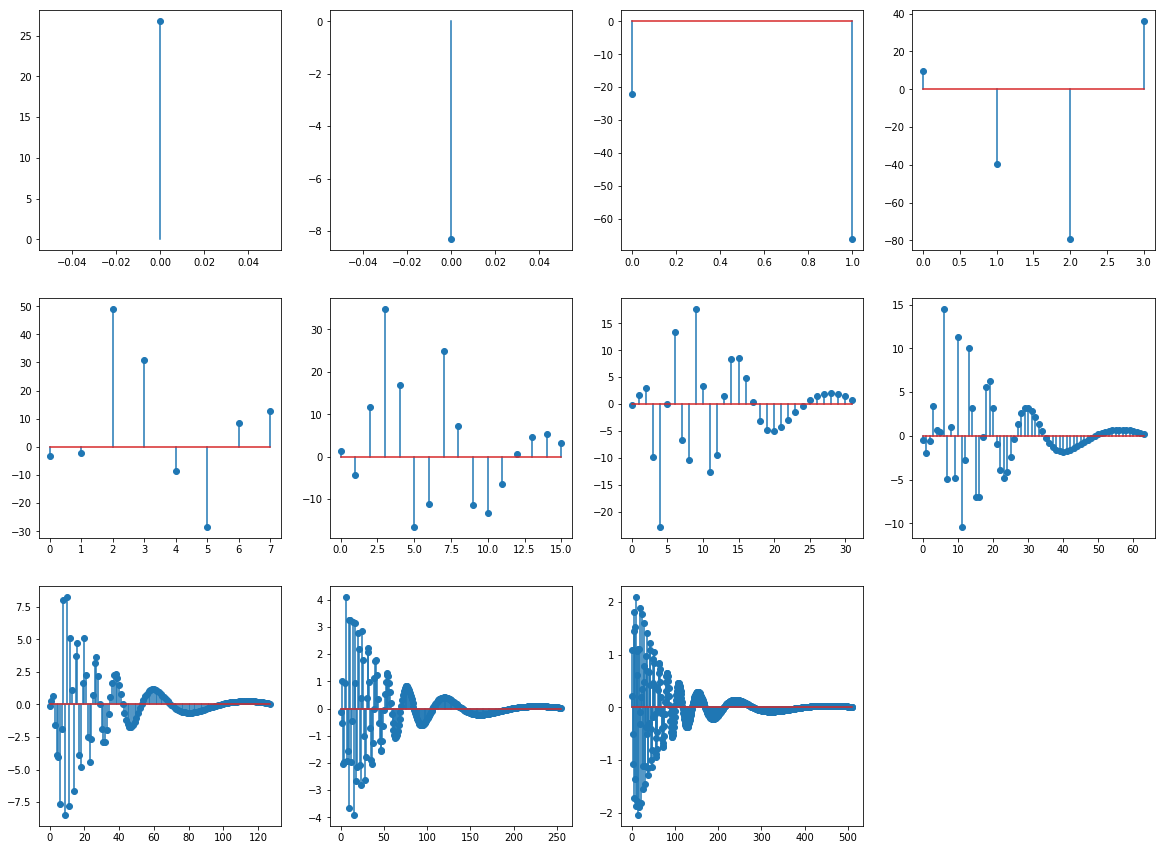

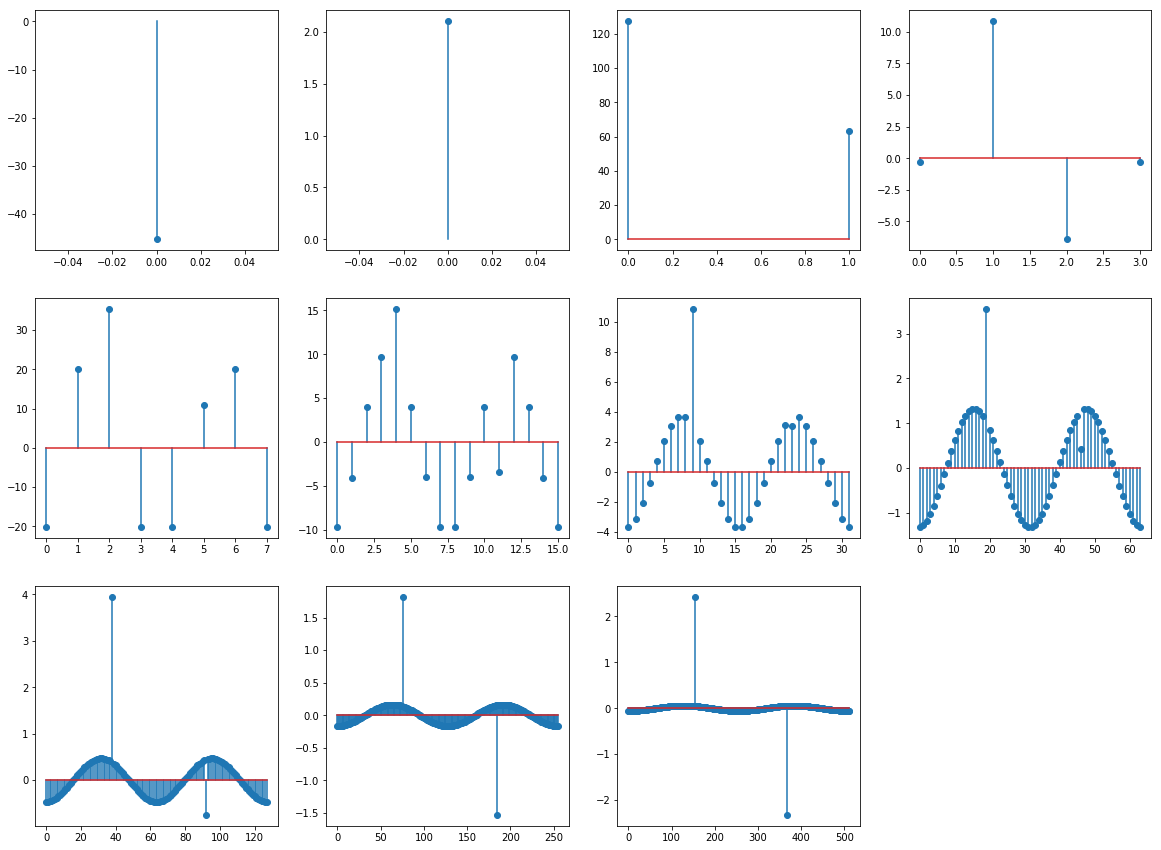

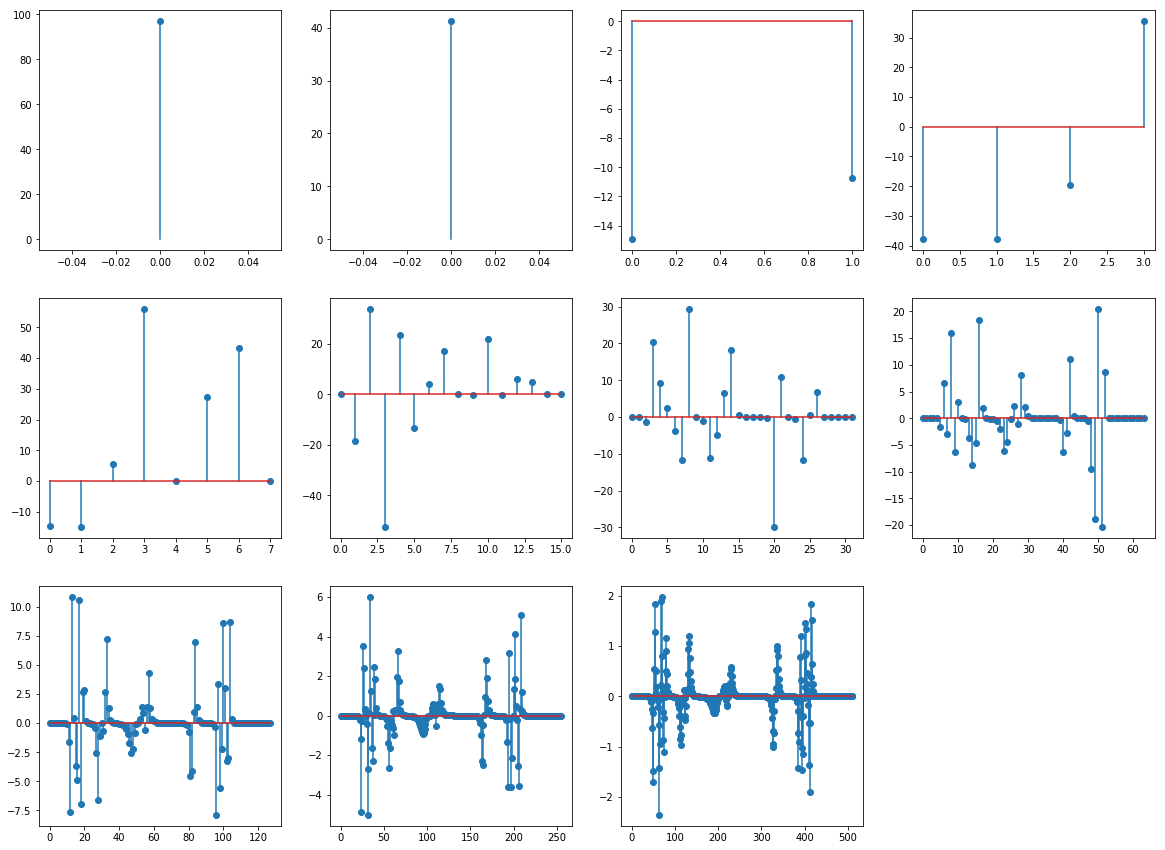

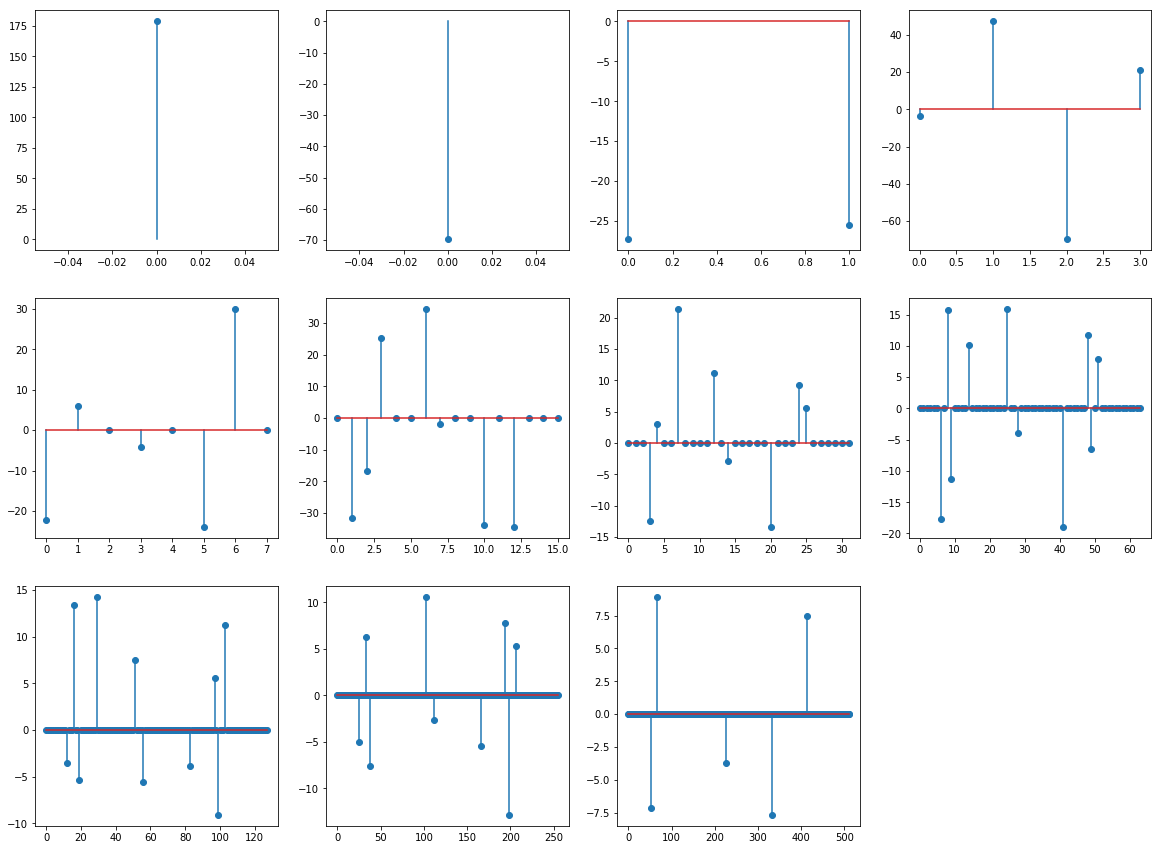

In [3]:
# We define the wavelet_family here and then use it throughout the notebook.
wavelet_family = 'haar'
# You can turn off plotting the results for testing by setting this to False.
enablePlot = True

# Wavelet transform of clean signal using given wavelet_family
w_clean = pywt.wavedec(clean_signal, wavelet_family, axis=0)

# Plot all levels for all clean signals
if enablePlot:
    plotsPerRow = 4
    for signal_idx in range(4):
        plt.figure(figsize=(20,15))
        for i in range(len(w_clean)):
            plt.subplot(np.ceil(float(len(w_clean))/float(plotsPerRow)),plotsPerRow,i+1)
            plt.stem(w_clean[i][:,signal_idx])
        plt.show()

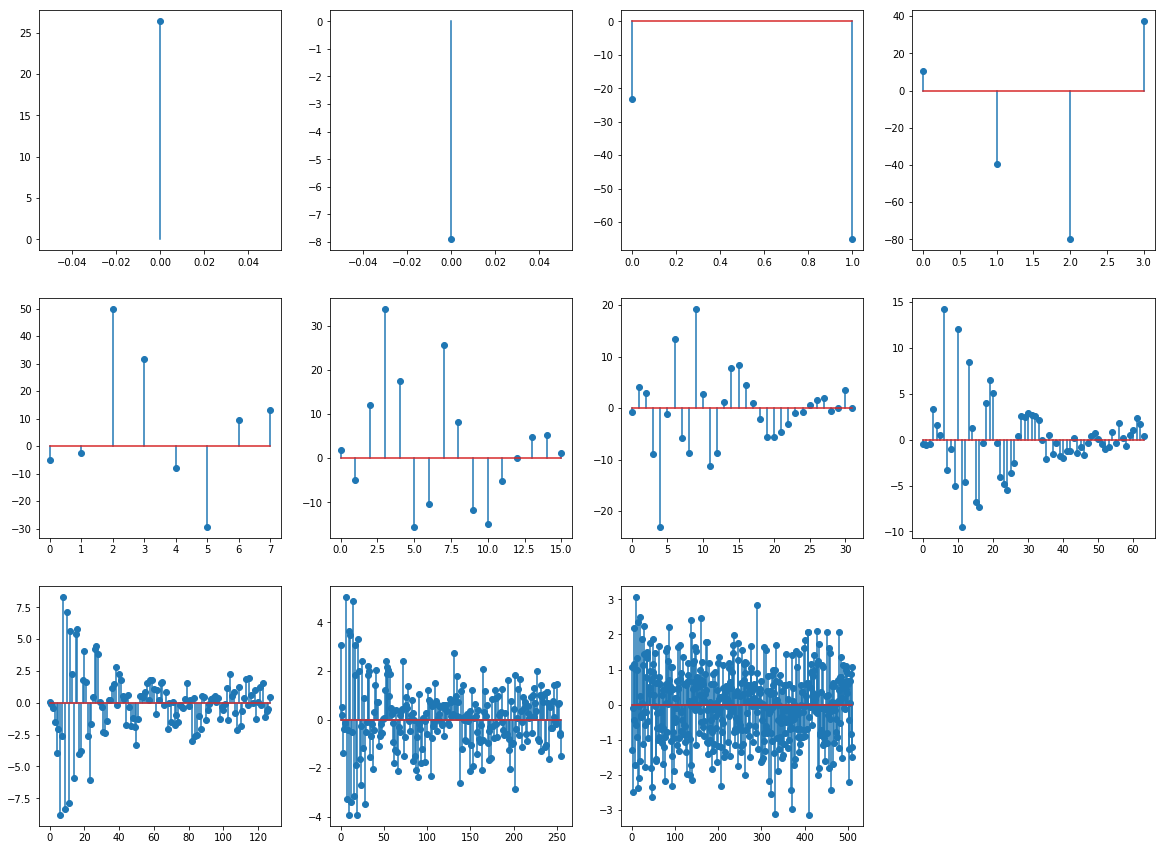

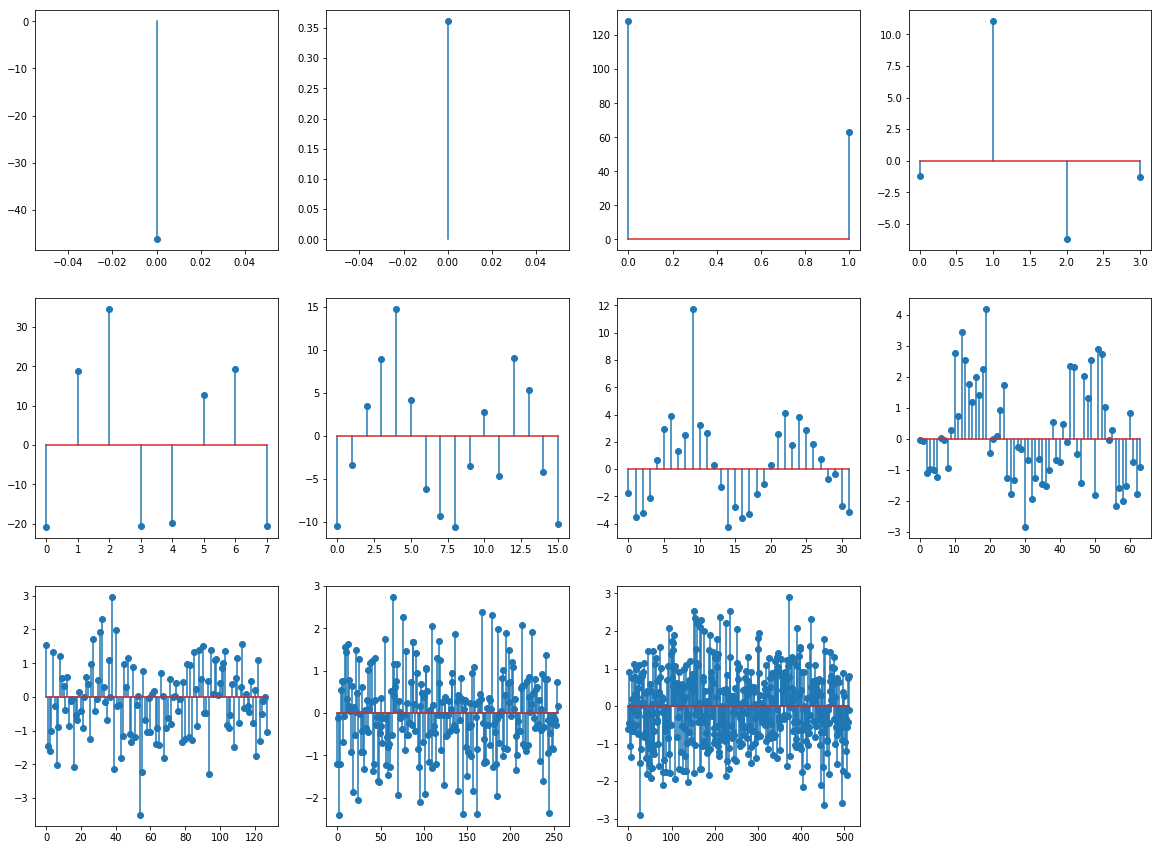

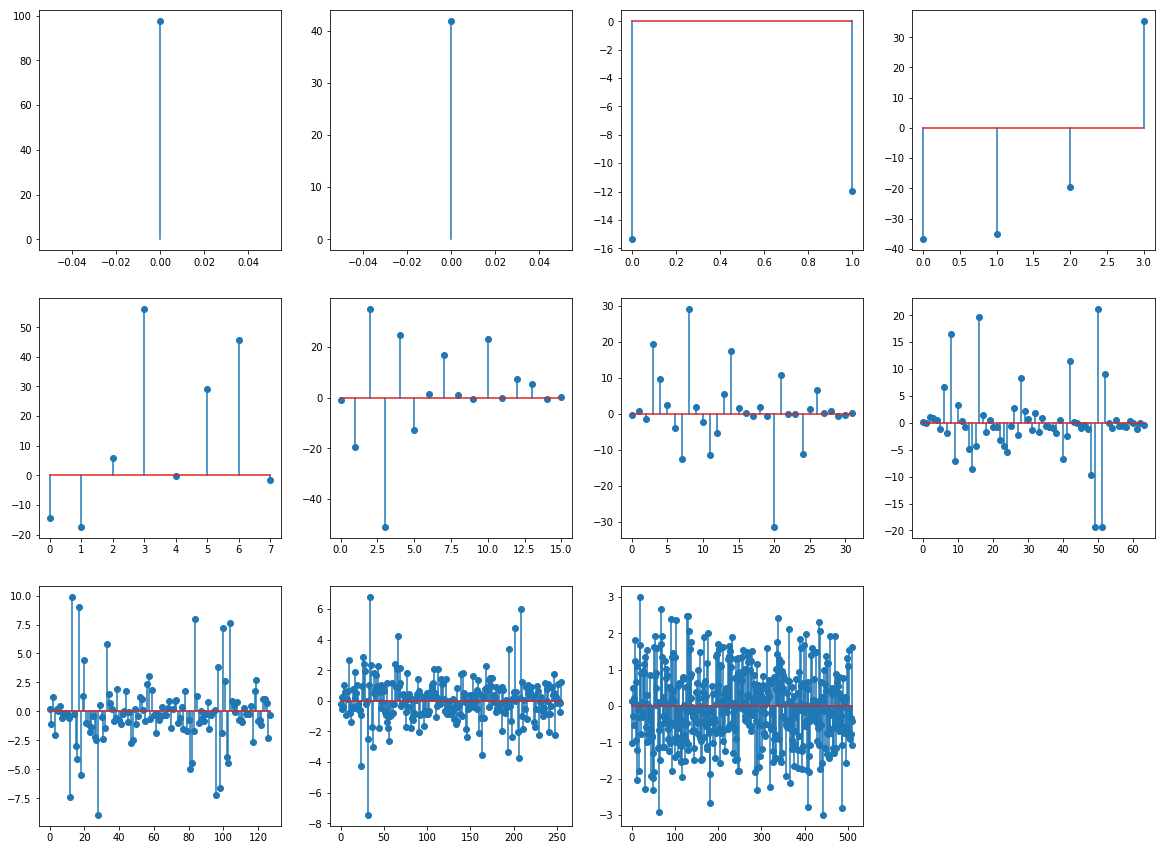

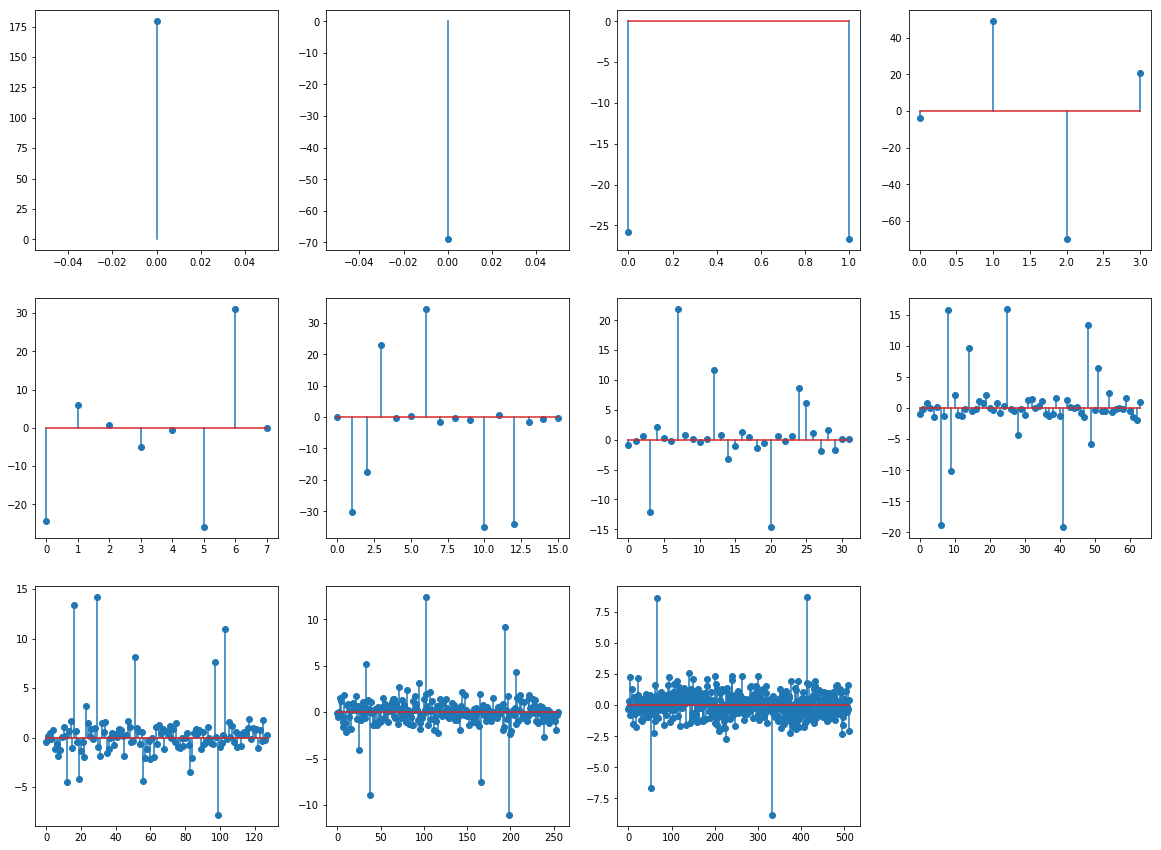

In [4]:
# Wavelet transform of noisy signal
w_noisy = pywt.wavedec(noisy_signal, wavelet_family, axis=0)

# Plot all levels for all noisy signals
if enablePlot:
    for signal_idx in range(4):
        plt.figure(figsize=(20,15))
        for i in range(len(w_clean)):
            plt.subplot(np.ceil(float(len(w_noisy))/float(plotsPerRow)),plotsPerRow,i+1)
            plt.stem(w_noisy[i][:,signal_idx])
        plt.show()

2\. Use the soft thresholding formula derived in class to denoise the signals. Take the inverse wavelet transfrom and visualize the results. Report the l2 norm of the difference between the clean signal and the reconstructed signal. Compare it to the l2 norm of the difference between the clean signal and the noisy signal. By how much were you able to denoise?

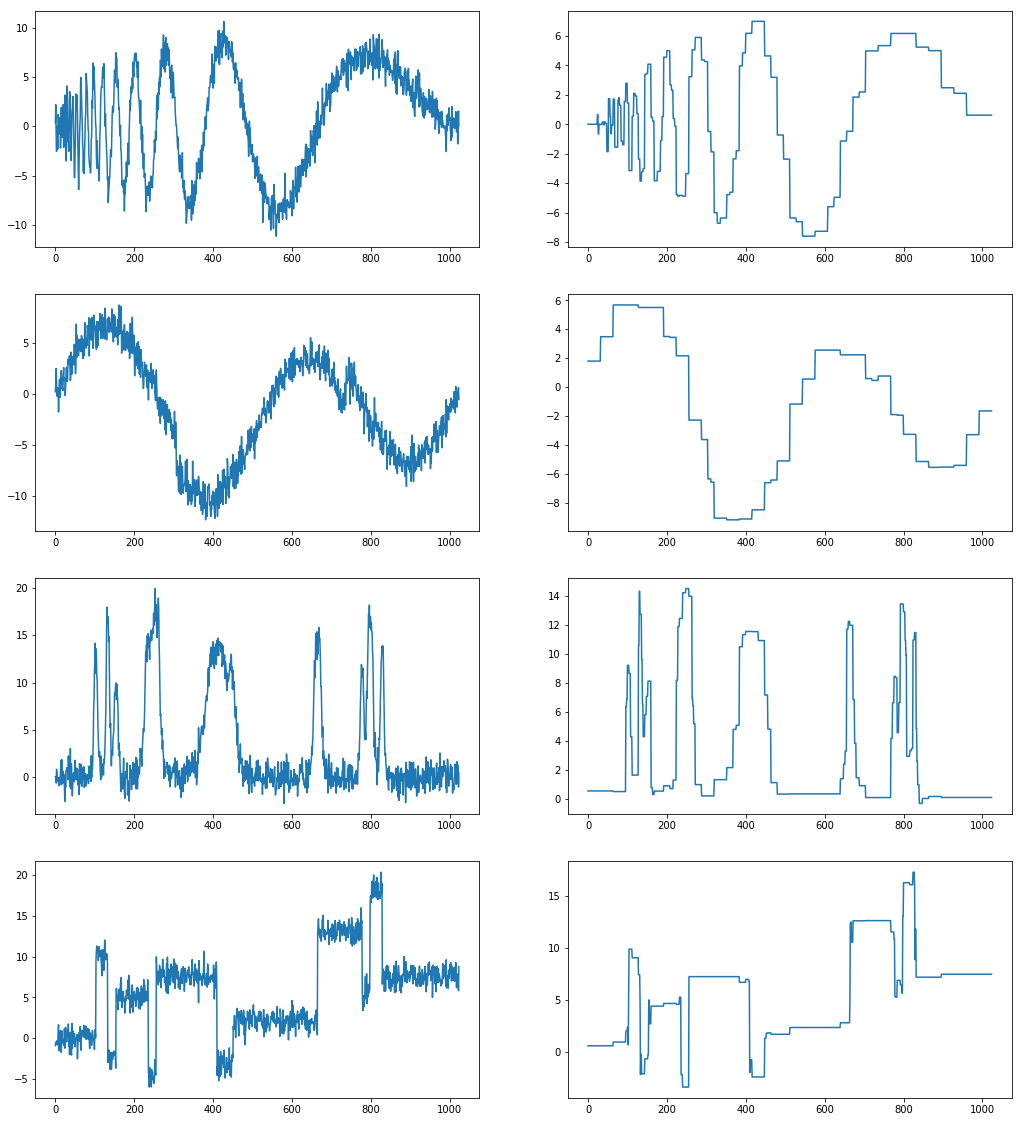

In [5]:
# Parameters for soft thresholding
sigma = 1.
thresh = sigma*np.sqrt(2*np.log(clean_signal.shape[0]))

# Initialize denoised wavelet coefficients
w_denoised = list(w_noisy)
# Soft thresholding loop (pywt stores coeffiecients of different levels in different arrays, loop through them)
for i in range(len(w_clean)):
    # Apply soft thresholding. Refer to numpy's documentation to understand what np.where is doing.
    w_denoised[i] = np.where(w_noisy[i]>thresh,w_noisy[i]-thresh,np.where(w_noisy[i]<-thresh,w_noisy[i]+thresh,np.zeros_like(w_noisy[i])))
denoised_signal = pywt.waverec(w_denoised,wavelet_family,axis=0)

# Plot the denoised signals
x = np.arange(noisy_signal.shape[0])
plt.figure(figsize=(17.5,20))
for i in range(4):
    plt.subplot(4,2,2*i+1)
    plt.plot(x,noisy_signal[:,i])
    plt.subplot(4,2,2*i+2)
    plt.plot(x,denoised_signal[:,i])
plt.show()

3\. Form the wavelet transform matrix corresponding to the wavelet transform that you used above. This is a 1024 × 1024 matrix in this case.

$\textbf{Hint}$: To form this matrix, you can generate all the standard basis vectors (1 sparse vectors with exactly one nonzero element) one-by-one and apply pywt.wavedec to each of these vectors. This recovers the corresponding wavelet transform matrix column-by-column.

In [6]:
# Initialize wavelet transform matrix
W_T = np.zeros((1024,1024))

# Extract wavelet transform matrix from pywt wavedec
for i in range(1024):
    e = np.zeros(1024)
    e[i] = 1
    W_T[:,i] = np.concatenate(pywt.wavedec(e, wavelet_family, axis=0))

4\. Use cvxpy to implement wavelet shrinkage in the form of l1 minimization problem.

In [9]:
# Rename thresh to lambda (following lecture notes)
lamda = thresh

# Define cvxpy problem. Here, theta corresponds to the wavelet coefficients.
theta = cvx.Variable(1024)
objective = cvx.Minimize(cvx.square(cvx.norm(noisy_signal[:,3]-W_T.T*theta,2)) + 2*lamda*cvx.norm(theta,1))
opt = cvx.Problem(objective).solve()

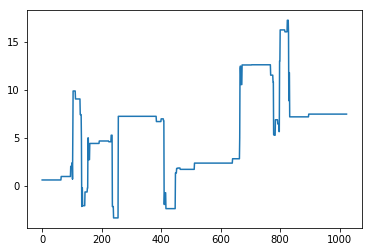

In [10]:
denoised_cvx = W_T.T.dot(theta.value)
plt.plot(x, denoised_cvx)
plt.show()